In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix
from tqdm import tqdm

class Layer:
    def __init__(self):
        pass

    def forward(self, A):
        pass

    def backward(self, dZ):
        pass

class DenseLayer(Layer):
    def __init__(self, input_size, output_size, activation='relu'):
        self.W = np.random.randn(output_size, input_size) * np.sqrt(2/input_size) # He initialization
        self.b = np.zeros((output_size, 1))
        self.activation_function = ActivationLayer(activation)

    def forward(self, A):
        Z = self.W.dot(A) + self.b
        assert Z.shape == (self.W.shape[0], A.shape[1])
        return Z

    def backward(self, dZ, A_prev):
        m = A_prev.shape[1]
        dW = 1./m * np.dot(dZ, A_prev.T)
        db = 1./m * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(self.W.T, dZ)
        
        assert dA_prev.shape == A_prev.shape
        assert dW.shape == self.W.shape
        assert db.shape == self.b.shape
        
        return dA_prev, dW, db

class DropoutLayer(Layer):
    def __init__(self, rate):
        self.rate = rate
        self.mask = None

    def forward(self, A):
        self.mask = np.random.rand(*A.shape) > self.rate
        A = A * self.mask
        A /= (1 - self.rate)
        return A

    def backward(self, dA):
        dA = dA * self.mask
        dA /= (1 - self.rate)
        return dA

class ActivationLayer(Layer):
    def __init__(self, activation):
        self.activation = activation
        self.activation_cache = None

    def forward(self, Z):
        self.activation_cache = Z
        if self.activation == "relu":
            A = np.maximum(0, Z)
            assert A.shape == Z.shape
            return A
        elif self.activation == "sigmoid":
            A = 1 / (1 + np.exp(-Z))
            assert A.shape == Z.shape
            return A
        elif self.activation == "softmax":
            e_x = np.exp(Z)
            A = e_x / np.sum(e_x, axis=0)
            assert A.shape == Z.shape
            return A

    def backward(self, dA):
        Z = self.activation_cache
        if self.activation == "relu":
            dZ = np.array(dA, copy=True)
            dZ[Z <= 0] = 0
            assert dZ.shape == Z.shape
            return dZ
        elif self.activation == "sigmoid":
            s = 1 / (1 + np.exp(-Z))
            dZ = dA * s * (1 - s)
            assert dZ.shape == Z.shape
            return dZ
        elif self.activation == "softmax":
            # For this case, dA = Y_true
            e_x = np.exp(Z)
            s = e_x / np.sum(e_x, axis=0)
            dZ = s - dA
            assert dZ.shape == Z.shape
            return dZ

class Network:
    def __init__(self):
        self.layers = []
        self.cache = []
        self.costs = []
        self.train_acc = []
        self.test_acc = []
        self.test_costs = []

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, X, training=True):
        A = X
        self.cache = [(None, X)]
        for layer in self.layers:
            if isinstance(layer, DropoutLayer) and training:
                A = layer.forward(A)
            elif isinstance(layer, DenseLayer):
                Z = layer.forward(A)
                A = layer.activation_function.forward(Z)
                self.cache.append((Z, A))
        assert A.shape == (26, X.shape[1])
        return A

    def backward(self, Y, AL):
        gradients = {}
        Y = Y.reshape(AL.shape)
        L = len(self.layers)
        dA_prev = Y  # Assuming last layer uses softmax
        self.cache.pop()
        for i in reversed(range(L)):
            layer = self.layers[i]
            if isinstance(layer, DropoutLayer):
                dA_prev = layer.backward(dA_prev)
            elif isinstance(layer, DenseLayer):
                Z, A_prev = self.cache.pop()
                dZ = layer.activation_function.backward(dA_prev)
                dA_prev, dW, db = layer.backward(dZ, A_prev)
                gradients["dW" + str(i+1)] = dW
                gradients["db" + str(i+1)] = db

        return gradients

    def update_parameters(self, gradients):
        for i, layer in enumerate(self.layers):
            if isinstance(layer, DenseLayer):
                layer.W -= self.learning_rate * gradients["dW" + str(i+1)]
                layer.b -= self.learning_rate * gradients["db" + str(i+1)]

    def train(self, X_train, y_train, epochs, learning_rate=0.1, batch_size=64, valid_split=0.2):
        self.learning_rate = learning_rate
        X_train, y_train, X_valid, y_valid = self.train_test_split(X_train, y_train, valid_split=valid_split)
        num_examples = X_train.shape[1]
        num_batches = num_examples // batch_size
        for epoch in range(epochs):
            train_cost = 0
            for j in tqdm(range(0, num_examples, batch_size)):
                start = j
                end = min(j+batch_size, num_examples)
                X_batch = X_train[:, start:end]
                y_batch = y_train[:, start:end]
                output = self.forward(X_batch)
                cost = self.compute_cost(output, y_batch)
                train_cost += cost
                gradients = self.backward(y_batch, output)
                self.update_parameters(gradients)

            # Compute cost and accuracy
            test_cost = self.compute_cost(self.forward(X_valid), y_valid)
            train_cost /= num_batches
            _, train_acc = self.predict(X_train, y_train)
            _, test_acc = self.predict(X_valid, y_valid)
            self.costs.append(train_cost)
            self.test_costs.append(test_cost)
            self.train_acc.append(train_acc)
            self.test_acc.append(test_acc)
            
            print(f'Epoch: {epoch+1}/{epochs}, train_cost: {train_cost:.5f}, test_cost: {test_cost:.5f}, train_acc: {train_acc:.5f}, test_acc: {test_acc:.5f}')
            
    def predict(self, X, y):
        m = X.shape[1]   # X = (768, m)
        # y = (26, m)
        y_hat = self.forward(X, training=False)
        p = np.argmax(y_hat, axis=0)
        y = np.argmax(y, axis=0)
        correct = np.sum(p == y)
        # print(f"train examples: {m}, correctly predicted: {correct}, accuracy: {correct/m}")
        return p, correct/m

    @staticmethod
    def compute_cost(AL, Y):
        m = Y.shape[1]
        cost = (-1./m) * np.sum(Y * np.log(AL))
        cost = np.squeeze(cost)
        assert cost.shape == ()
        return cost
    
    def train_test_split(self, X, y, valid_split=0.2):
        # Number of examples
        num_examples = X.shape[1]
        # Splitting the data
        valid_split = int(num_examples * valid_split)
        X_train = X[:, valid_split:]
        y_train = y[:, valid_split:]
        X_valid = X[:, :valid_split]
        y_valid = y[:, :valid_split]

        return X_train, y_train, X_valid, y_valid
    
    def plot_cost(self):
        plt.plot(np.squeeze(self.costs))
        plt.plot(np.squeeze(self.test_costs))
        plt.legend(['train', 'test'], loc='upper right')
        plt.ylabel('cost')
        plt.xlabel('epoch')
        plt.title("Learning rate = " + str(self.learning_rate))
        plt.show()
        
    def plot_acc(self):
        plt.plot(np.squeeze(self.train_acc))
        plt.plot(np.squeeze(self.test_acc))
        plt.legend(['train', 'test'], loc='upper left')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title("Learning rate = " + str(self.learning_rate))
        plt.show()



In [2]:
import torchvision.datasets as ds
import torchvision.transforms as transforms

# Load the EMNIST dataset for training and validation
train_validation_dataset = ds.EMNIST(root='./data', 
                                     split='letters',
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Load the EMNIST dataset for independent testing
independent_test_dataset = ds.EMNIST(root='./data',
                                     split='letters',
                                     train=False,
                                     transform=transforms.ToTensor())
# 28x28 ==> 768, 1
# 28x28, 2


In [3]:
def extract_data_and_labels(dataset):
    # Initialize lists to store data and labels
    data = []
    labels = []

    # Loop through the dataset
    for image_tensor, label in dataset:
        # Flatten the image tensor and convert to numpy array
        flattened_image = image_tensor.numpy().flatten()
        data.append(flattened_image)
        labels.append(label)

    # Convert lists to numpy arrays
    return np.array(data), np.array(labels)

# Extract data and labels from the datasets
X_train_raw, y_train_raw = extract_data_and_labels(train_validation_dataset)
print(f'X_train shape: {X_train_raw.shape}')
print(f'y_train shape: {y_train_raw.shape}')

X_test_raw, y_test_raw = extract_data_and_labels(independent_test_dataset)
print(f'X_test shape: {X_test_raw.shape}')
print(f'y_test shape: {y_test_raw.shape}')


X_train shape: (124800, 784)
y_train shape: (124800,)
X_test shape: (20800, 784)
y_test shape: (20800,)


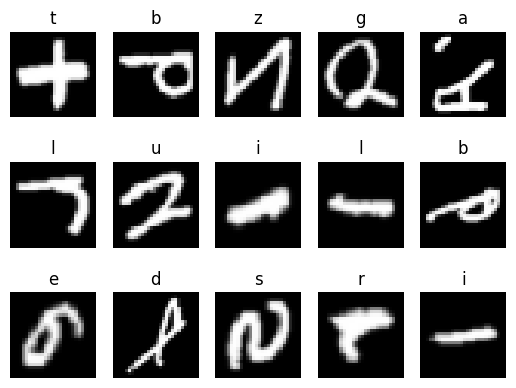

In [7]:
# plot some samples
import matplotlib.pyplot as plt
np.random.seed(1)

def plot_samples(X, y, nrows, ncols):
    fig, axes = plt.subplots(nrows, ncols)
    for i, ax in enumerate(axes.flatten()):
        random_index = np.random.randint(0, len(X))
        ax.imshow(X[random_index].reshape(28,28), cmap='gray')
        ax.set_title(chr(y[random_index]+96))
        ax.axis('off')
    plt.savefig('figures/1_training_samples.png', dpi=300, bbox_inches='tight')
    plt.show()
    
plot_samples(X_train_raw, y_train_raw, 3, 5)


In [8]:
m_train = X_train_raw.shape[0]
m_test = X_test_raw.shape[0]
num_px = X_train_raw.shape[1]


print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print(f'Number of pixels: {num_px}')
print ("train_set_x shape: " + str(X_train_raw.shape))
print ("train_set_y shape: " + str(y_train_raw.shape))
print ("test_set_x shape: " + str(X_test_raw.shape))
print ("test_set_y shape: " + str(y_test_raw.shape))


Number of training examples: 124800
Number of testing examples: 20800
Number of pixels: 784
train_set_x shape: (124800, 784)
train_set_y shape: (124800,)
test_set_x shape: (20800, 784)
test_set_y shape: (20800,)


In [9]:
X_train = X_train_raw.T
X_test = X_test_raw.T

print ("train_set_x_flatten shape: " + str(X_train.shape))
print("test_set_x_flatten shape: " + str(X_test.shape))

y_train = y_train_raw - 1
y_test = y_test_raw - 1

y_train = np.eye(26)[y_train.astype('int32')]
y_test = np.eye(26)[y_test.astype('int32')]
y_train = y_train.T
y_test = y_test.T
print ("train_set_y shape: " + str(y_train.shape))
print ("test_set_y shape: " + str(y_test.shape))

# Now shuffle the training set
np.random.seed(1)
permutation = list(np.random.permutation(m_train))
X_train = X_train[:, permutation]
y_train = y_train[:, permutation]
y_train_raw = y_train_raw[permutation]

train_set_x_flatten shape: (784, 124800)
test_set_x_flatten shape: (784, 20800)
train_set_y shape: (26, 124800)
test_set_y shape: (26, 20800)


In [35]:
# Example usage:
# np.random.seed(1)
# model = Network()
# model.add(DenseLayer(input_size=X_train.shape[0], output_size=256))
# model.add(DropoutLayer(rate=0.2))
# model.add(DenseLayer(input_size=256, output_size=128))
# model.add(DropoutLayer(rate=0.2))
# model.add(DenseLayer(input_size=128, output_size=64))
# model.add(DropoutLayer(rate=0.2))
# model.add(DenseLayer(input_size=64, output_size=64))
# model.add(DropoutLayer(rate=0.2))
# model.add(DenseLayer(input_size=64, output_size=64))
# model.add(DropoutLayer(rate=0.2))
# model.add(DenseLayer(input_size=64, output_size=26, activation='softmax'))
# # Assume X_train and y_train are defined
# model.train(X_train, y_train, epochs=80, batch_size=128, learning_rate=0.01, valid_split=0.05)

# Example usage:
np.random.seed(1)
model = Network()
model.add(DenseLayer(input_size=X_train.shape[0], output_size=128))
model.add(DropoutLayer(rate=0.2))
model.add(DenseLayer(input_size=128, output_size=64))
model.add(DropoutLayer(rate=0.2))
model.add(DenseLayer(input_size=64, output_size=64))
model.add(DropoutLayer(rate=0.2))
model.add(DenseLayer(input_size=64, output_size=26, activation='softmax'))
# Assume X_train and y_train are defined
model.train(X_train, y_train, epochs=60, batch_size=64, learning_rate=0.005, valid_split=0.15)

  0%|          | 0/1658 [00:00<?, ?it/s]

100%|██████████| 1658/1658 [00:04<00:00, 340.49it/s]


Epoch: 1/60, train_cost: 2.38365, test_cost: 1.52109, train_acc: 0.57028, test_acc: 0.56624


100%|██████████| 1658/1658 [00:05<00:00, 297.60it/s]


Epoch: 2/60, train_cost: 1.25019, test_cost: 1.11520, train_acc: 0.67954, test_acc: 0.67527


100%|██████████| 1658/1658 [00:05<00:00, 325.62it/s]


Epoch: 3/60, train_cost: 1.00842, test_cost: 0.96117, train_acc: 0.72684, test_acc: 0.72025


100%|██████████| 1658/1658 [00:05<00:00, 314.84it/s]


Epoch: 4/60, train_cost: 0.87974, test_cost: 0.85740, train_acc: 0.75762, test_acc: 0.75091


100%|██████████| 1658/1658 [00:04<00:00, 333.63it/s]


Epoch: 5/60, train_cost: 0.78677, test_cost: 0.77857, train_acc: 0.78141, test_acc: 0.77217


100%|██████████| 1658/1658 [00:04<00:00, 337.27it/s]


Epoch: 6/60, train_cost: 0.71506, test_cost: 0.71715, train_acc: 0.79897, test_acc: 0.78948


100%|██████████| 1658/1658 [00:05<00:00, 324.26it/s]


Epoch: 7/60, train_cost: 0.65845, test_cost: 0.66936, train_acc: 0.81287, test_acc: 0.80208


100%|██████████| 1658/1658 [00:05<00:00, 314.53it/s]


Epoch: 8/60, train_cost: 0.61305, test_cost: 0.63105, train_acc: 0.82427, test_acc: 0.81218


100%|██████████| 1658/1658 [00:05<00:00, 315.70it/s]


Epoch: 9/60, train_cost: 0.57615, test_cost: 0.59930, train_acc: 0.83343, test_acc: 0.81976


100%|██████████| 1658/1658 [00:04<00:00, 332.18it/s]


Epoch: 10/60, train_cost: 0.54565, test_cost: 0.57293, train_acc: 0.84102, test_acc: 0.82724


100%|██████████| 1658/1658 [00:04<00:00, 336.76it/s]


Epoch: 11/60, train_cost: 0.51982, test_cost: 0.55092, train_acc: 0.84751, test_acc: 0.83371


100%|██████████| 1658/1658 [00:05<00:00, 328.95it/s]


Epoch: 12/60, train_cost: 0.49779, test_cost: 0.53241, train_acc: 0.85273, test_acc: 0.84006


100%|██████████| 1658/1658 [00:05<00:00, 310.97it/s]


Epoch: 13/60, train_cost: 0.47859, test_cost: 0.51604, train_acc: 0.85801, test_acc: 0.84364


100%|██████████| 1658/1658 [00:05<00:00, 301.88it/s]


Epoch: 14/60, train_cost: 0.46148, test_cost: 0.50138, train_acc: 0.86275, test_acc: 0.84765


100%|██████████| 1658/1658 [00:04<00:00, 334.00it/s]


Epoch: 15/60, train_cost: 0.44623, test_cost: 0.48835, train_acc: 0.86697, test_acc: 0.85219


100%|██████████| 1658/1658 [00:05<00:00, 308.09it/s]


Epoch: 16/60, train_cost: 0.43250, test_cost: 0.47676, train_acc: 0.87100, test_acc: 0.85513


100%|██████████| 1658/1658 [00:04<00:00, 331.66it/s]


Epoch: 17/60, train_cost: 0.41998, test_cost: 0.46658, train_acc: 0.87435, test_acc: 0.85812


100%|██████████| 1658/1658 [00:05<00:00, 325.17it/s]


Epoch: 18/60, train_cost: 0.40854, test_cost: 0.45774, train_acc: 0.87750, test_acc: 0.86052


100%|██████████| 1658/1658 [00:04<00:00, 338.14it/s]


Epoch: 19/60, train_cost: 0.39808, test_cost: 0.44973, train_acc: 0.88043, test_acc: 0.86325


100%|██████████| 1658/1658 [00:04<00:00, 340.90it/s]


Epoch: 20/60, train_cost: 0.38848, test_cost: 0.44261, train_acc: 0.88295, test_acc: 0.86496


100%|██████████| 1658/1658 [00:04<00:00, 340.81it/s]


Epoch: 21/60, train_cost: 0.37964, test_cost: 0.43593, train_acc: 0.88556, test_acc: 0.86661


100%|██████████| 1658/1658 [00:04<00:00, 342.16it/s]


Epoch: 22/60, train_cost: 0.37140, test_cost: 0.42983, train_acc: 0.88763, test_acc: 0.86886


100%|██████████| 1658/1658 [00:04<00:00, 340.55it/s]


Epoch: 23/60, train_cost: 0.36371, test_cost: 0.42420, train_acc: 0.88966, test_acc: 0.86987


100%|██████████| 1658/1658 [00:04<00:00, 335.50it/s]


Epoch: 24/60, train_cost: 0.35658, test_cost: 0.41918, train_acc: 0.89150, test_acc: 0.87147


100%|██████████| 1658/1658 [00:04<00:00, 336.43it/s]


Epoch: 25/60, train_cost: 0.34984, test_cost: 0.41470, train_acc: 0.89359, test_acc: 0.87324


100%|██████████| 1658/1658 [00:04<00:00, 335.23it/s]


Epoch: 26/60, train_cost: 0.34346, test_cost: 0.41059, train_acc: 0.89512, test_acc: 0.87473


100%|██████████| 1658/1658 [00:05<00:00, 314.98it/s]


Epoch: 27/60, train_cost: 0.33745, test_cost: 0.40659, train_acc: 0.89685, test_acc: 0.87671


100%|██████████| 1658/1658 [00:05<00:00, 291.67it/s]


Epoch: 28/60, train_cost: 0.33175, test_cost: 0.40301, train_acc: 0.89823, test_acc: 0.87756


100%|██████████| 1658/1658 [00:05<00:00, 302.61it/s]


Epoch: 29/60, train_cost: 0.32636, test_cost: 0.40006, train_acc: 0.89990, test_acc: 0.87826


100%|██████████| 1658/1658 [00:05<00:00, 325.70it/s]


Epoch: 30/60, train_cost: 0.32120, test_cost: 0.39719, train_acc: 0.90135, test_acc: 0.87885


100%|██████████| 1658/1658 [00:05<00:00, 298.50it/s]


Epoch: 31/60, train_cost: 0.31628, test_cost: 0.39449, train_acc: 0.90283, test_acc: 0.88007


100%|██████████| 1658/1658 [00:05<00:00, 305.72it/s]


Epoch: 32/60, train_cost: 0.31158, test_cost: 0.39199, train_acc: 0.90395, test_acc: 0.88104


100%|██████████| 1658/1658 [00:05<00:00, 303.14it/s]


Epoch: 33/60, train_cost: 0.30708, test_cost: 0.38960, train_acc: 0.90499, test_acc: 0.88200


100%|██████████| 1658/1658 [00:05<00:00, 300.63it/s]


Epoch: 34/60, train_cost: 0.30279, test_cost: 0.38714, train_acc: 0.90603, test_acc: 0.88216


100%|██████████| 1658/1658 [00:05<00:00, 305.60it/s]


Epoch: 35/60, train_cost: 0.29867, test_cost: 0.38505, train_acc: 0.90741, test_acc: 0.88248


100%|██████████| 1658/1658 [00:04<00:00, 332.96it/s]


Epoch: 36/60, train_cost: 0.29471, test_cost: 0.38307, train_acc: 0.90866, test_acc: 0.88237


100%|██████████| 1658/1658 [00:05<00:00, 315.81it/s]


Epoch: 37/60, train_cost: 0.29086, test_cost: 0.38136, train_acc: 0.90964, test_acc: 0.88280


100%|██████████| 1658/1658 [00:05<00:00, 299.24it/s]


Epoch: 38/60, train_cost: 0.28716, test_cost: 0.37990, train_acc: 0.91090, test_acc: 0.88376


100%|██████████| 1658/1658 [00:05<00:00, 310.22it/s]


Epoch: 39/60, train_cost: 0.28360, test_cost: 0.37840, train_acc: 0.91154, test_acc: 0.88467


100%|██████████| 1658/1658 [00:05<00:00, 309.64it/s]


Epoch: 40/60, train_cost: 0.28018, test_cost: 0.37685, train_acc: 0.91256, test_acc: 0.88510


100%|██████████| 1658/1658 [00:04<00:00, 335.65it/s]


Epoch: 41/60, train_cost: 0.27686, test_cost: 0.37539, train_acc: 0.91367, test_acc: 0.88542


100%|██████████| 1658/1658 [00:05<00:00, 328.32it/s]


Epoch: 42/60, train_cost: 0.27365, test_cost: 0.37412, train_acc: 0.91457, test_acc: 0.88558


100%|██████████| 1658/1658 [00:05<00:00, 324.88it/s]


Epoch: 43/60, train_cost: 0.27056, test_cost: 0.37299, train_acc: 0.91530, test_acc: 0.88606


100%|██████████| 1658/1658 [00:05<00:00, 306.22it/s]


Epoch: 44/60, train_cost: 0.26750, test_cost: 0.37186, train_acc: 0.91609, test_acc: 0.88600


100%|██████████| 1658/1658 [00:05<00:00, 306.77it/s]


Epoch: 45/60, train_cost: 0.26457, test_cost: 0.37073, train_acc: 0.91702, test_acc: 0.88686


100%|██████████| 1658/1658 [00:05<00:00, 305.24it/s]


Epoch: 46/60, train_cost: 0.26170, test_cost: 0.36982, train_acc: 0.91797, test_acc: 0.88739


100%|██████████| 1658/1658 [00:05<00:00, 308.85it/s]


Epoch: 47/60, train_cost: 0.25895, test_cost: 0.36905, train_acc: 0.91850, test_acc: 0.88675


100%|██████████| 1658/1658 [00:05<00:00, 323.69it/s]


Epoch: 48/60, train_cost: 0.25628, test_cost: 0.36798, train_acc: 0.91924, test_acc: 0.88734


100%|██████████| 1658/1658 [00:05<00:00, 302.46it/s]


Epoch: 49/60, train_cost: 0.25371, test_cost: 0.36717, train_acc: 0.92000, test_acc: 0.88745


100%|██████████| 1658/1658 [00:05<00:00, 278.68it/s]


Epoch: 50/60, train_cost: 0.25120, test_cost: 0.36652, train_acc: 0.92064, test_acc: 0.88739


100%|██████████| 1658/1658 [00:05<00:00, 288.07it/s]


Epoch: 51/60, train_cost: 0.24878, test_cost: 0.36570, train_acc: 0.92128, test_acc: 0.88739


100%|██████████| 1658/1658 [00:05<00:00, 291.25it/s]


Epoch: 52/60, train_cost: 0.24640, test_cost: 0.36481, train_acc: 0.92197, test_acc: 0.88766


100%|██████████| 1658/1658 [00:05<00:00, 304.69it/s]


Epoch: 53/60, train_cost: 0.24410, test_cost: 0.36421, train_acc: 0.92276, test_acc: 0.88846


100%|██████████| 1658/1658 [00:05<00:00, 306.83it/s]


Epoch: 54/60, train_cost: 0.24184, test_cost: 0.36366, train_acc: 0.92356, test_acc: 0.88868


100%|██████████| 1658/1658 [00:05<00:00, 297.83it/s]


Epoch: 55/60, train_cost: 0.23964, test_cost: 0.36329, train_acc: 0.92422, test_acc: 0.88900


100%|██████████| 1658/1658 [00:05<00:00, 285.82it/s]


Epoch: 56/60, train_cost: 0.23749, test_cost: 0.36281, train_acc: 0.92505, test_acc: 0.88910


100%|██████████| 1658/1658 [00:05<00:00, 282.07it/s]


Epoch: 57/60, train_cost: 0.23539, test_cost: 0.36242, train_acc: 0.92552, test_acc: 0.88926


100%|██████████| 1658/1658 [00:05<00:00, 300.21it/s]


Epoch: 58/60, train_cost: 0.23334, test_cost: 0.36200, train_acc: 0.92599, test_acc: 0.88926


100%|██████████| 1658/1658 [00:05<00:00, 304.21it/s]


Epoch: 59/60, train_cost: 0.23130, test_cost: 0.36159, train_acc: 0.92656, test_acc: 0.88996


100%|██████████| 1658/1658 [00:05<00:00, 306.91it/s]


Epoch: 60/60, train_cost: 0.22931, test_cost: 0.36150, train_acc: 0.92717, test_acc: 0.88948


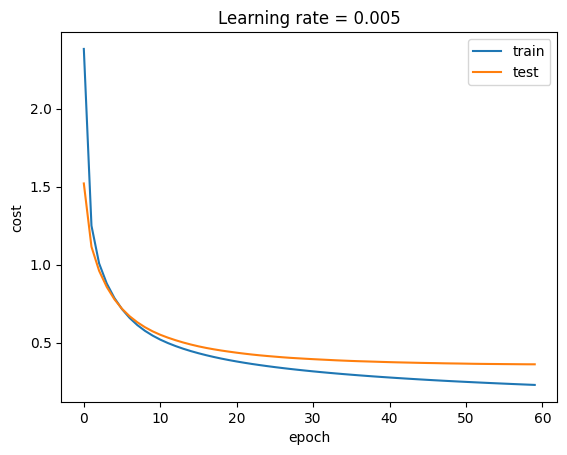

In [36]:
model.plot_cost()

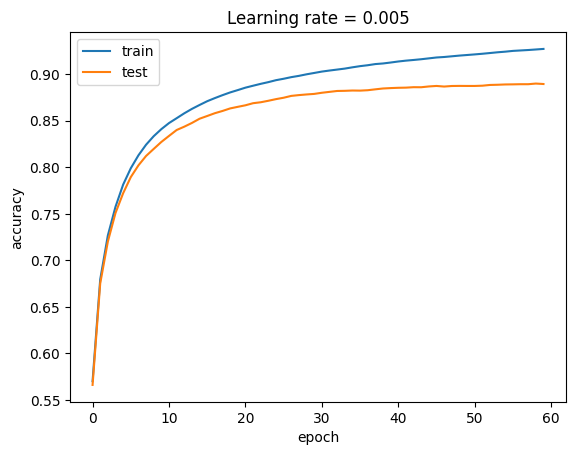

In [37]:
model.plot_acc()

In [33]:
y_hat, acc = model.predict(X_test, y_test)
print(f'Test accuracy: {acc}')

Test accuracy: 0.8680769230769231


In [15]:
y_hat, acc = model.predict(X_train, y_train)
print(f'Train accuracy: {acc}')

Train accuracy: 0.8853365384615385


Test accuracy: 0.8623076923076923


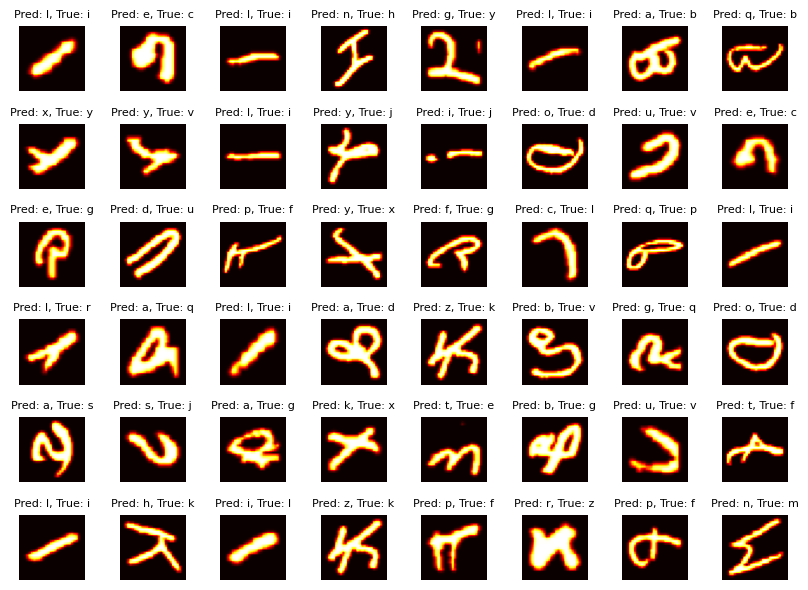

In [16]:
# visualize misclassified examples
def plot_misclassified(X, y, y_hat, nrows, ncols):
    np.random.seed(1)
    fig, axes = plt.subplots(nrows, ncols)
    fig.set_size_inches(ncols, nrows)
    correctly_classified = np.where(y == y_hat)[0]
    misclassified = np.where(y != y_hat)[0]
    for i, ax in enumerate(axes.flatten()):
        random_index = np.random.choice(misclassified)
        ax.imshow(X[:, random_index].reshape(28,28), cmap='hot')
        ax.set_title(f'Pred: {chr(y_hat[random_index]+97)}, True: {chr(y[random_index]+97)}', fontsize=8)
        ax.axis('off')
    fig.tight_layout()
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    plt.show()

y_hat, acc = model.predict(X_test, y_test)
print(f'Test accuracy: {acc}')
plot_misclassified(X_test, y_test_raw - 1, y_hat, 6, 8)

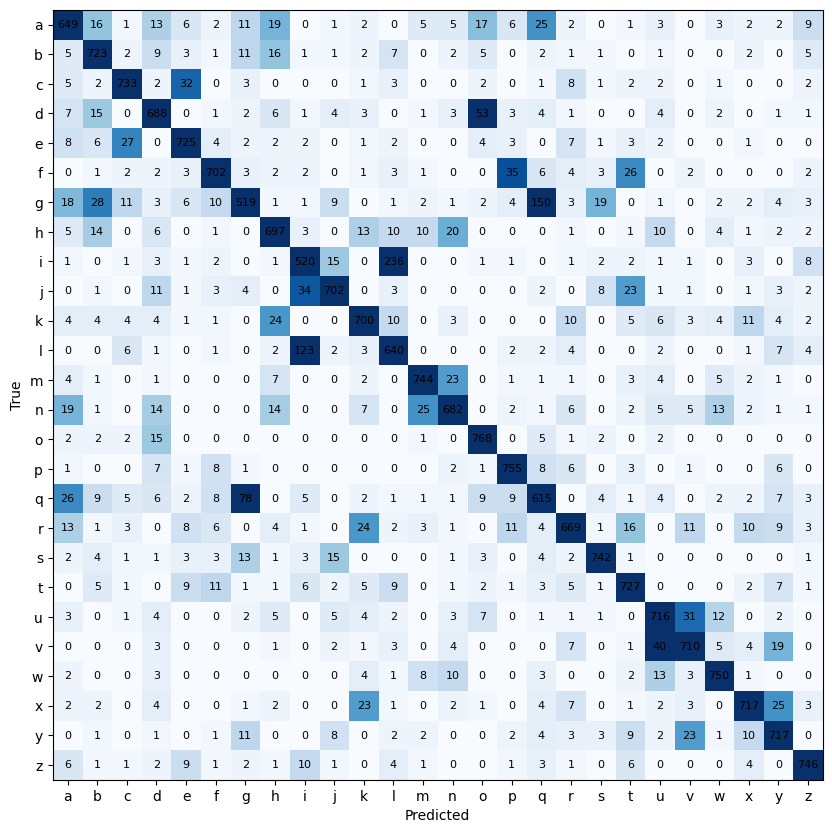

In [34]:
C_counts = confusion_matrix(y_test_raw - 1, y_hat)
C = confusion_matrix(y_test_raw - 1, y_hat, normalize='true')

fig = plt.figure(figsize=(10, 10))
plt.imshow(C, 'Blues', vmax=0.05)
# also show the numbers
for i in range(26):
    for j in range(26):
        plt.text(j, i, f'{C_counts[i, j]}', horizontalalignment='center', verticalalignment='center', fontsize=8)
plt.xticks(range(26), labels=[chr(i+97) for i in range(26)])
plt.yticks(range(26), labels=[chr(i+97) for i in range(26)])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [18]:
# Calculate validation macro F1 score
# Use built-in sklearn function
y_hat, acc = model.predict(X_test, y_test)
print(f'Test accuracy: {acc}')
macro_f1 = f1_score(y_test_raw - 1, y_hat, average='macro')
print(f'Test macro F1 score: {macro_f1:.5f}')

Test accuracy: 0.8623076923076923
Test macro F1 score: 0.86251
